In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from decimal import ROUND_HALF_UP, Decimal
from statsmodels.api import OLS
import random
import statsmodels.api as sm
from ta.volatility import BollingerBands
from tqdm.auto import tqdm
tqdm.pandas()


In [2]:
train_stock_prices = pd.read_csv('ds/train_files/stock_prices.csv')
supplemental_stock_prices = pd.read_csv('ds/supplemental_files/stock_prices.csv')
data_stock_prices = pd.concat([train_stock_prices,supplemental_stock_prices],ignore_index=True)

In [3]:
def calc_adjusted_close(df):
    df = df.sort_values("Date",ascending=False)
    df.loc[:,"cummulative_adjustment_factor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:,"adjusted_close"] = (df["cummulative_adjustment_factor"]*df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_open"] = (df["cummulative_adjustment_factor"]*df["Open"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_high"] = (df["cummulative_adjustment_factor"]*df["High"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df.loc[:,"adjusted_low"] = (df["cummulative_adjustment_factor"]*df["Low"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_close"]==0,"adjusted_close"] = np.nan
    df.loc[:,"adjusted_close"] = df.loc[:,"adjusted_close"].ffill()
    return df

In [4]:
def calc_adjusted_volume(df):
    df.loc[:,"adjusted_volume"] = (df["Volume"]/df["cummulative_adjustment_factor"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_volume"]==0,"adjusted_volume"] = np.nan
    df.loc[:,"adjusted_volume"] = df.loc[:,"adjusted_volume"].ffill()
    return df

In [5]:

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        #Target is the rate of change 
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    print(buf.mean())
    print(buf.std())
    buf.plot()
    return sharpe_ratio

In [6]:
def create_bands(df):
    indicator_bb =  BollingerBands(close=df["adjusted_close"],window=28,window_dev=2)
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    df["difference_upper"] = df['adjusted_close']-df["bb_bbm"]
    df["difference_lower"] = df['bb_bbl'] - df["adjusted_close"]
    return df

In [7]:
def create_deciles(df):
    df = df.sort_values("difference_upper",ascending=False)
    to_buy_index = df.index[:200]
    df = df.sort_values("difference_lower",ascending=False)
    to_short_index = df.index[:200]
    df.loc[to_buy_index,"Quarter"] = 0
    df.loc[to_buy_index,"Abs"] = df.loc[to_buy_index,"difference_upper"]
    df.loc[to_short_index,"Quarter"] = 2
    df.loc[to_short_index,"Abs"] = df.loc[to_short_index,"adjusted_close"]-df.loc[to_short_index,"bb_bbl"]
    df["Quarter"]=df["Quarter"].fillna(1)
    df = df.sort_values(["Quarter","Abs"],ascending=[True,False])
    return df

In [8]:
def create_features(df):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.drop(["RowId"],axis=1)
    df = df[df["Date"]!="2020-10-01"]
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_close).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_volume).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    df = df.groupby("SecuritiesCode").apply(create_bands)
    df = df.groupby("Date").apply(create_deciles).reset_index(0,drop=True)
    df=df.dropna(subset=['difference_upper'])
    df["Rank"] = df.groupby(["Date"])["SecuritiesCode"].transform(lambda x: np.linspace(0,x.count()-1,x.count()))
    return df

In [9]:
test = create_features(train_stock_prices)

-0.08954318618750355
1.6086571086124422


-0.05566331426884354

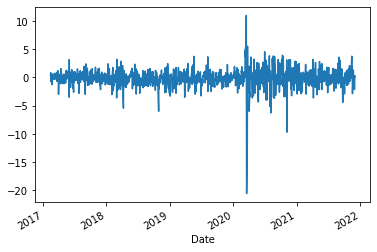

In [10]:
calc_spread_return_sharpe(test)

In [11]:
test

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,adjusted_low,adjusted_volume,bb_bbm,bb_bbh,bb_bbl,difference_upper,difference_lower,Quarter,Abs,Rank
51130,2017-02-13,5217,836.0,941.0,810.0,929.0,109000,1.0,NaN,False,...,8100.0,10900.0,6608.214286,8401.519722,4814.908849,2681.785714,-4475.091151,0.0,2681.785714,0
51297,2017-02-13,6273,31900.0,32300.0,31820.0,31930.0,305900,1.0,NaN,False,...,31820.0,305900.0,29530.535714,32674.688268,26386.383161,2399.464286,-5543.616839,0.0,2399.464286,1
51266,2017-02-13,6146,17030.0,17080.0,16910.0,16990.0,191300,1.0,NaN,False,...,16910.0,191300.0,14781.071429,16568.178742,12993.964115,2208.928571,-3996.035885,0.0,2208.928571,2
51673,2017-02-13,7717,18250.0,19080.0,18130.0,18670.0,1058600,1.0,NaN,False,...,9065.0,2117200.0,7902.142857,10174.147052,5630.138662,1432.857143,-3704.861338,0.0,1432.857143,3
51517,2017-02-13,6954,22790.0,22920.0,22620.0,22705.0,687200,1.0,NaN,False,...,22620.0,687200.0,21385.357143,23172.327701,19598.386585,1319.642857,-3106.613415,0.0,1319.642857,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328980,2021-12-03,3635,4625.0,4635.0,4495.0,4550.0,1606300,1.0,NaN,False,...,4495.0,1606300.0,5147.500000,5624.308587,4670.691413,-597.500000,120.691413,2.0,-120.691413,1995
2328969,2021-12-03,3563,4725.0,4725.0,4400.0,4445.0,1964900,1.0,NaN,False,...,4400.0,1964900.0,4947.678571,5294.516143,4600.841000,-502.678571,155.841000,2.0,-155.841000,1996
2328762,2021-12-03,2593,6070.0,6350.0,5970.0,6290.0,311800,1.0,NaN,False,...,5970.0,311800.0,7311.428571,8169.061765,6453.795378,-1021.428571,163.795378,2.0,-163.795378,1997
2328848,2021-12-03,3031,1191.0,1193.0,1155.0,1155.0,1651500,1.0,NaN,False,...,1155.0,1651500.0,1589.285714,1791.450327,1387.121102,-434.285714,232.121102,2.0,-232.121102,1998
